# Genetic clock by *Danino et al. 2010*

From:

Danino, T., Mondragón-Palomino, O., Tsimring, L. et al. A synchronized quorum of genetic clocks. Nature 463, 326–330 (2010). https://doi.org/10.1038/nature08753

This oscillator produces luxI, which in turn causes production of self, GFP and AiiA production. AiiA degrades LuxI.

First, install the latest version of LOICA Consortia.

In [1]:
pip install -e .

Note: you may need to restart the kernel to use updated packages.


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: c:\Users\User\OneDrive\Desktop\Masters PJ\GitHub\LOICA\notebooks\compare_to_papers


In [2]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Then add gene products involved in genetic networks. 

Since AiiA acts as a repressor by degradation of AHL and current LOICA does not have a class for degradation enzymes, I encode AiiA as regulator that represses Plux

In [3]:
oscillator = lc.GeneticNetwork()

# TODO: determine degr rate
luxi = lc.Regulator(name='AHL', init_concentration=0, degradation_rate=0, diffusion_rate=1)
aiia = lc.Regulator(name="AiiA", degradation_rate=0)
gfp = lc.Reporter(name="yemGFP", degradation_rate=1, color='green')

oscillator.add_regulator([luxi, aiia])
oscillator.add_reporter(gfp)

# TODO: find a, K and n
# ahl_luxi = lc.Hill1(luxi, luxi, a=[1, 100], K=10, n=2, name='Plux')
# ahl_gfp = lc.Hill1(luxi, gfp, a=[1,100], K=10, n=2, name='Plux')
# ahl_aiia = lc.Hill1(luxi, aiia, a=[1,100], K=10, n=2, name='Plux')

# if AHL(luxI) activates Plux, while if there is enough AiiA, AHL will be degraded.
aiia_luxi_luxi = lc.Hill2(input=[aiia, luxi], output=luxi, alpha=[0.001, 0.001, 2500, 0.001], K=[10, 10], n=[2, 2], name='Plux')
aiia_luxi_gfp = lc.Hill2(input=[aiia, luxi], output=gfp, alpha=[0.001, 0.001, 2500, 0.001], K=[10, 10], n=[2, 2], name='Plux')
aiia_luxi_aiia = lc.Hill2(input=[aiia, luxi], output=aiia, alpha=[0.001, 0.001, 2500, 0.001], K=[10, 10], n=[2, 2], name='Plux')

oscillator.add_operator([aiia_luxi_luxi, aiia_luxi_gfp, aiia_luxi_aiia])

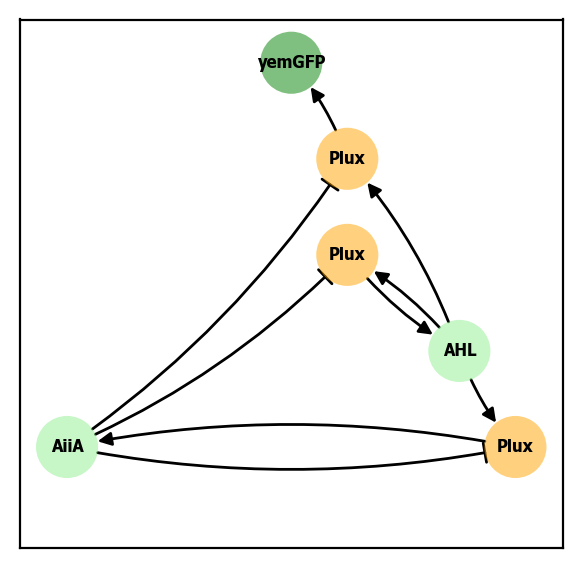

In [4]:
plt.figure(figsize=(3.5,3.5), dpi=200)
oscillator.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [5]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 0.5)

metab = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
clock_strain = lc.Strain(name="E. coli", genetic_network=oscillator, metabolism=metab)

In [6]:
sample = lc.Sample(strain=clock_strain)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Quorum clock',
                description='Simulated GFP expression of quorum clock by Danino et al. (2010)'
                )

In [7]:
assay.run(stochastic=False, track_all=True)

100%|██████████| 100.0/100 [00:46<00:00,  2.13it/s]


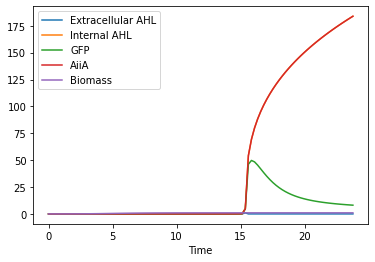

In [8]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='Extracellular AHL'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='AHL in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='yemGFP in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='AiiA in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='E. coli biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
plt.legend(['Extracellular AHL', 'Internal AHL', 'GFP', 'AiiA', 'Biomass'])